In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# архитектура модели +
# загрузчик данных +
# формирование батча +
# оптимизатор +
# функция потерь +
# опционально шедулеры -
# трейн луп

In [ ]:
dataset = datasets.MNIST('.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F77BB660ED0>, 5)

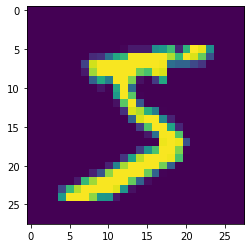

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(dataset.data[0].detach().numpy())
plt.show()

In [ ]:
class LinearModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activation(self.linear1(x)))
    x = self.do2(self.activation(self.linear2(x)))

    return self.linear3(x)

In [ ]:
def collate_fn(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.view(pics.size(0), -1),
      'target': target,
      }


In [ ]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device).long())
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model.state_dict(), f'./chkpt_{epoch}.pth')


epoch: 0, step: 0, loss: 0.12249290198087692
epoch: 0, step: 200, loss: 0.24017056822776794
epoch: 0, step: 400, loss: 0.1549384891986847
epoch: 1, step: 0, loss: 0.12096979469060898
epoch: 1, step: 200, loss: 0.06916451454162598
epoch: 1, step: 400, loss: 0.06709090620279312
epoch: 2, step: 0, loss: 0.05119345337152481
epoch: 2, step: 200, loss: 0.06573870033025742
epoch: 2, step: 400, loss: 0.15291669964790344
epoch: 3, step: 0, loss: 0.008098946884274483
epoch: 3, step: 200, loss: 0.057723868638277054
epoch: 3, step: 400, loss: 0.032891012728214264
epoch: 4, step: 0, loss: 0.014680977910757065
epoch: 4, step: 200, loss: 0.0423479862511158
epoch: 4, step: 400, loss: 0.032180897891521454
epoch: 5, step: 0, loss: 0.012095769867300987
epoch: 5, step: 200, loss: 0.03171423077583313
epoch: 5, step: 400, loss: 0.045335203409194946
epoch: 6, step: 0, loss: 0.0671374574303627
epoch: 6, step: 200, loss: 0.046244341880083084
epoch: 6, step: 400, loss: 0.012357275933027267
epoch: 7, step: 0, lo

# Новый раздел

In [ ]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, 
                           kernel_size=5, padding=2, stride=2) # уменьшаем картинку в 2 раза
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 2, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(2)
    self.linear3 = nn.Linear(2 * 14 * 14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    self.do2 = nn.Dropout(dropout_p)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activation(self.bn1(self.conv1(x))))
    x = self.do2(self.activation(self.bn2(self.conv2(x))))
    x = self.activation(self.bn3(self.conv3(x))) # B x 2 x 14 x 14

    return self.linear3(x.view(x.size(0), -1))
    # x.size() -> (B, W, H); x.size(0) -> B
    # x.view(B, -1) -> (B, вектор размера всего остального)

In [ ]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [ ]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()

    predict = model_conv(batch['data'].to(device))
    loss = loss_func(predict, batch['target'].to(device))
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  torch.save(model_conv.state_dict(), f'./chkpt_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 0.06629426032304764
epoch: 0, step: 200, loss: 0.04192550480365753
epoch: 0, step: 400, loss: 0.04311186075210571
epoch: 1, step: 0, loss: 0.03498481214046478
epoch: 1, step: 200, loss: 0.10859944671392441
epoch: 1, step: 400, loss: 0.007670458406209946
epoch: 2, step: 0, loss: 0.07601185888051987
epoch: 2, step: 200, loss: 0.05631548538804054
epoch: 2, step: 400, loss: 0.05243667960166931
epoch: 3, step: 0, loss: 0.044371750205755234
epoch: 3, step: 200, loss: 0.013263498432934284
epoch: 3, step: 400, loss: 0.01092423964291811
epoch: 4, step: 0, loss: 0.01984805427491665
epoch: 4, step: 200, loss: 0.036766260862350464
epoch: 4, step: 400, loss: 0.03571028262376785
epoch: 5, step: 0, loss: 0.01220676489174366
epoch: 5, step: 200, loss: 0.028104720637202263
epoch: 5, step: 400, loss: 0.027817456051707268
epoch: 6, step: 0, loss: 0.040251508355140686
epoch: 6, step: 200, loss: 0.01630057767033577
epoch: 6, step: 400, loss: 0.007985858246684074
epoch: 7, step: 0, 